<a href="https://colab.research.google.com/github/neflem27/Algorithmic_Insights-My_Machine_Learning_Library/blob/main/Ch6_Decision_Trees(HOMLKT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6: Decision Trees

*Decision trees* are versitile Machine Learning algorithms suitable for **classification and regression** tasks with one or multiple outputs and are the fundamental component of *Random Forests*, which are the most powerful Machine Learning algorithms today.

This chapter overview discusses how to train, visualize, and make predictions with Decision Trees. Then we will go through the Cart training algorithm used by Sciki-Learn, and we will discuss some of the limitations of Decision Trees.


## Training and Visualizing a Decision Tree

To understand Decision Trees, let's build one and take a look at how it makes predictions.

The following code trains a `DecisionTreeClassifier`on the iris dataset:


In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
x = iris.data[:,2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(x,y)

DecisionTreeClassifier(max_depth=2)

To visualize the Decision Tree we can use the `export_graphvis()` method to output a graph file and display it via `graphviz.Source.from_file()`.


In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file = "iris_tree.dot",
    feature_names = iris.feature_names[2:],
    class_names=iris.target_names,
    rounded = True,
    filled = True
)

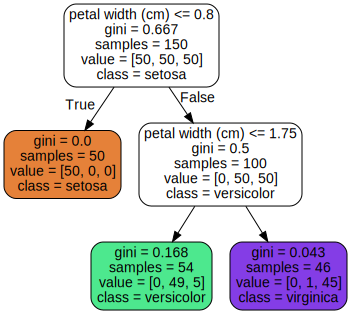

In [ ]:
from graphviz import Source
Source.from_file('iris_tree.dot')

## Making Predictions

Suppose you find an iris flower and you want to classify it.

* You start at the **root node** (depth 0, at the top): this node asks whether the flower’s petal width is smaller than or equal 0.8 cm.

* If true, then you move down to the root’s left **child node** (depth 1, left). In this case, it is a **leaf node** (i.e., it does not have any children nodes), so it does not ask any questions: you can simply look at the predicted class for that node and the Decision Tree predicts that your flower is an Iris-Setosa (class=setosa).

Now suppose you find another flower, but this time the petal width is greater than 0.8 cm.

* You must move down to the root’s right child node (depth 1, right), which is not a leaf node, so it asks another question: is the petal width smaller than 1.75 cm?

* If true, then your flower is most likely an Iris-Versicolor (depth 2, left).

* If not, it is likely an Iris-Virginica (depth 2, right).

**One of the many qualities of Decision Trees is that they require
very little data preparation. In particular, they don’t require feature
scaling or centering at all.**

A node's **sample attributes** acounts how many training instances it applies to. For example, 100 training instances have a petal length less than or equal 0.8 cm, among which 54 have a petal width smaller than 1.75 cm. A node's **value attribute** tells you how many training instances of each class this node applies to: for example, the bottom right node applies to 0 Iris-Setosa, 1, Versicolor, and 45 Iris-Virginica. Finally, a node's **gini attribute** measures its **impurity**: a node is pure (gini=0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris-Setosa training instances, it is pure and its gini score is 0. Equation 6-1 shows how the training algorithm computes the gini score Gi of the ith node. For example, the depth-2 left node has a gini score equal to 1 – (0/54)2 – (49/54)2 – (5/54 2 ≈ 0.168.


Equation 6-1. Gini Impurity

$$G_i = 1 - \sum_{k=1}^{n}{p_{i,k}}^2$$

* $p_{i,k}$ is the ratio of class k instances among the training instances in the $i^{th}$ node.

**Scikit-Learn uses the CART algorithm, which produces only binary
trees: nonleaf nodes always have two children (i.e., questions only
have yes/no answers). However, other algorithms such as ID3 can
produce Decision Trees with nodes that have more than two children.**

The figure below shows this Decision Tree’s decision boundaries. The thick vertical line represents the decision boundary of the root node (depth 0): petal width <= 0.8 cm. Since the left area is pure (only Iris-Setosa), it cannot be split any further. However,
the right area is impure, so the depth-1 right node splits it at petal width <= 1.75 cm (represented by the dashed line). Since max_depth was set to 2, the Decision Tree stops right there. However, if you set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).




In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving decision tree.png to decision tree.png


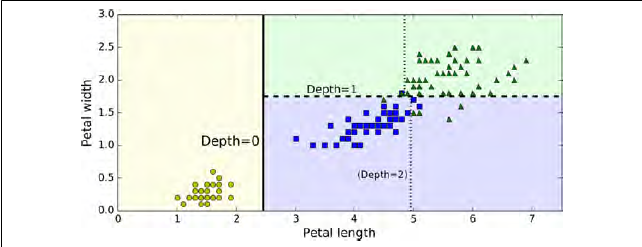

In [ ]:
Image('decision tree.png', width = 550)

As you can see Decision Trees are fairly intuitive and their decisions are easy to interpret.

**Such models are often called white box models.**

## Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a particular class $k$. First it transverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node.

For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide.

The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities: 0% for *Iris setosa* (0/54), 90.7% for *Iris versicolor* (49/54), and 9.3% for *Iris virginia* (5/54). And if you ask it to predict the class, it outputs *Iris versicolor* (class 1) because it has the highest probability. Let's check this:


In [ ]:
tree_clf.predict_proba([[5,1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [ ]:
tree_clf.predict([[5,1.5]])

array([1])

## The CART Training Algorithm
Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train decision trees. The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g. petal width <= 0.8 cm). How does it chose $k$ and $t_k$? It searches for the pair ($k$,$t_k$) that produces the purest subsets, weighted by their size. Equation 6-2 gives the cost function that the algorithm tries to minimize.

Equation 6-2. CART cost function for classification.

$$J(k,t_k) =  \frac{m_{left}}{m}G_{left} + \frac{m_{rigth}}{m}G_{rigth}$$

* where $G_{left/rigth}$ measures the impurity of the left/rigth subset
* where $m_{left/rigth}$ is the rigth number of instances in the left/rigth subset

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches
the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters (described in a moment) control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `min_weigth_fraction_leaf`, and `max_leaf_nodes`.

**The CART algorithm is a *greedy algorithm*: it greedily
searches for an optimum split at the top level, then repeats the
process at each level. It does not check whether or not the split will
lead to the lowest possible impurity several levels down. A greedy
algorithm often produces a reasonably good solution, but it is not
guaranteed to be the optimal solution.**


## Computational Complexity

Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees are generally approximately balanced, so traversing the Decision Tree requires going through roughly O(log2(m)) nodes.3 Since each node only requires
checking the value of one feature, the overall prediction complexity is just O(log2(m)), independent of the number of features. So predictions are very fast, even when dealing with large training sets. However, the training algorithm compares all features (or less if max_features is set) on all samples at each node. This results in a training complexity of O(n × m log(m)).
For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set presort=True), but this slows down training considerably
for larger training sets.


## Gini Impurity or Entropy

By default, the Gini impurity measure is used, but you can select the *entropy* impurity measure instead by setting the criterion hyperparameter to "entropy". The concept of entropy originated in thermodynamics as a measure of molecular disorder:
entropy approaches zero when molecules are still and well ordered. It later spread to a wide variety of domains, including Shannon’s information theory, where it measure the average information content of a message: entropy is zero when all messages are
identical. In Machine Learning, it is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. Equation 6-3 shows the definition of the entropy of the $i_{th}$ node. For example, the depth-2 left node in
Figure 6-1 has an entropy equal to − (49/54) log(49/54) − (5/54) log (5/54) ≈ 0.31.

Equation 6-3. Entropy

$$H_i = \sum_{k=1}^{n} p_{i,k}log_2(p_{i,k}) $$ where $p_{i,k} \not= 0$


There is no big difference between using Gini Impurity or entropy as they lead to similar trees. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce more balanced trees.

## Regularization Hyperparameters

Decision trees make very few assumptions about the training data that if left unconstrained, the tree model can overfit the data. Such a model is often called a *nonparametric model*, not because it does not have any parameters but because the number of parameters is not determined prior to training.

In contrast, a *parametric model*, such as a linear regression model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the decision tree's freedom during training. This is called **regularization**. These regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the decision tree with `max_depth`. The default value is "None", which means unlimited. Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the decision tree.

**max_features**: Maximum number of features that are evaluated for splitting at each node

**max_leaf_nodes**: Maximum number of leaf nodes

**min_samples_split**: Minumum number of samples a node must have before it can be split

**min_samples_leaf**: Minimum number of samples a leaf node must have to be created

**min_weight_fraction_leaf**: Same as **min_samples_leaf** but expressed as a fraction of the total number of weighted instances

Let's test regularization on the moons dataset, introduced in Chapter 5. We'll train one decision tree without regularization, an another **with min_samples_leaf=5**:

In [3]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise = 0.2, random_state = 42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [8]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving 6_3DT.jpg to 6_3DT.jpg


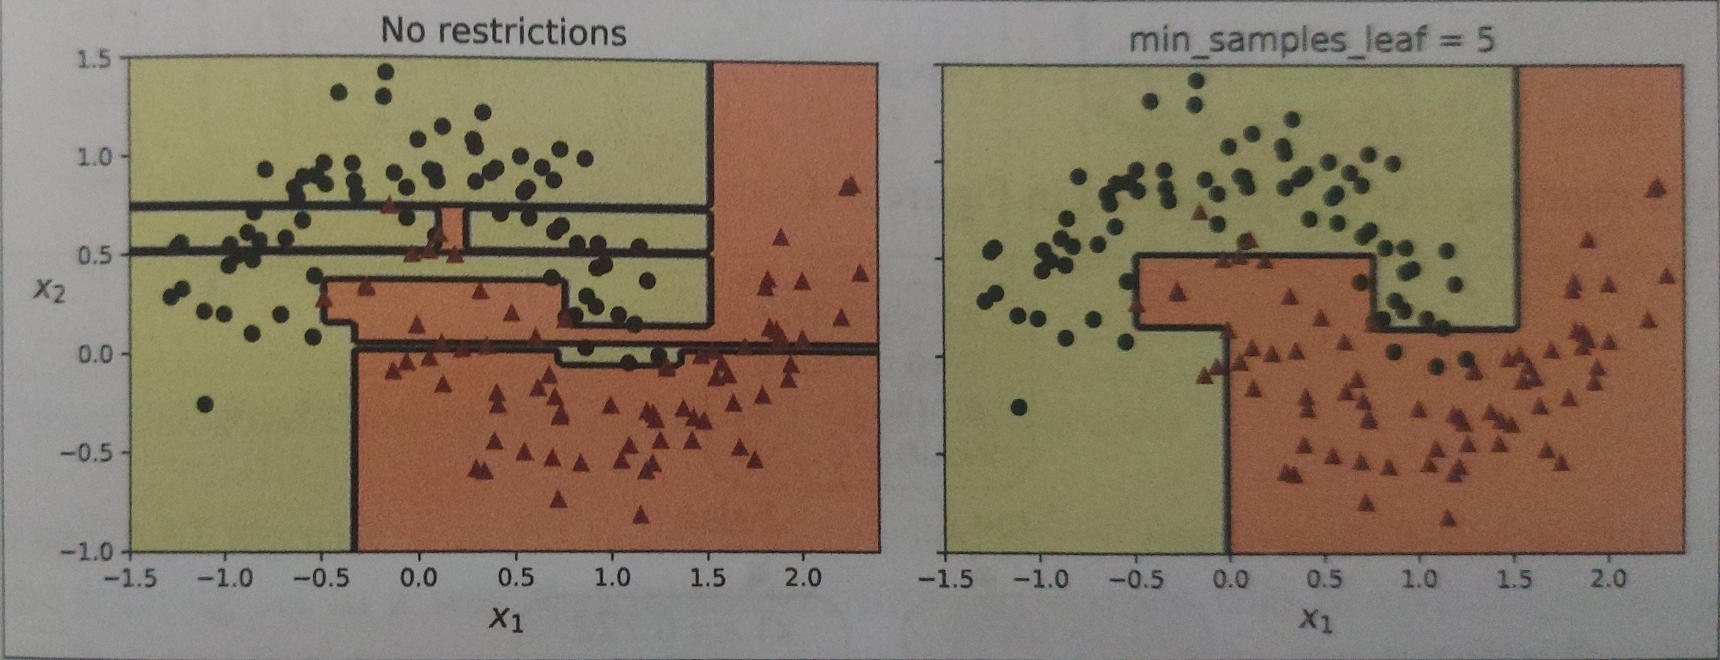

In [9]:
Image('6_3DT.jpg', width = 550)

The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better. we can verify this by evaluating both trees on a test set generated using a random seed:


In [7]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=42)
print(tree_clf1.score(X_moons_test, y_moons_test))
print(tree_clf2.score(X_moons_test, y_moons_test))

0.901
0.918


By this test we can confirm that model 2 has a better accuracy on the test set.